## CS 733 Final Project: Fine-Tuning a Pre-Trained Model for our Domain Specific Problem

### Elizabeth Trahadias

This notebook uses Hugging Face functions to fine-tune pre-trained masked langauge models. The purpose of this is to help our language model identify some of the key words that are specific to our problem set. We would not want the models to treat important words in our text as rare. Fine-tuning these models may produce better results in subsequent tasks like image captioning. We will explore **BERT, Albert, and SciBERT** in this notebook.

Sources: 
* https://huggingface.co/docs/transformers/main_classes/trainer
* https://huggingface.co/course/chapter7/3?fw=tf
* https://huggingface.co/docs/transformers/model_doc/auto
* https://towardsdatascience.com/fine-tuning-for-domain-adaptation-in-nlp-c47def356fd6
* https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import json
import requests
import time
import cv2

import torch
import transformers
import sklearn
from datasets import Dataset

from sklearn.model_selection import train_test_split

from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoConfig
from transformers import BertForMaskedLM
from transformers import AlbertForMaskedLM
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer

In [2]:
import session_info
session_info.show()

### Clean and Tokenized Text

First, let's read in our dataset with the captions.

In [2]:
df=pd.read_csv('BEES/Sources_captions.csv')

In [3]:
df.head()

,url,file,license,note,caption
0,https://live.staticflickr.com/7466/27401150176...,BEES/Unhealthy/292.jpg,0,chalkbrood,"Grey, white, and black chalkbrood mummies sit ..."
1,https://live.staticflickr.com/7387/27435735775...,BEES/Unhealthy/293.jpg,0,chalkbrood,A pile of gray and white chalkbrood mummies si...
2,https://live.staticflickr.com/8681/16200799428...,BEES/Unhealthy/294.jpg,0,chalkbrood,Discolored chalkbrood mummies can be seen in b...
3,https://live.staticflickr.com/7316/27030739643...,BEES/Unhealthy/295.jpg,0,sacbrood,A gondola shaped bee larva is seen in an open ...
4,https://live.staticflickr.com/7296/16387517262...,BEES/Unhealthy/296.jpg,0,chalkbrood,A bee larva with chalkbrood has fungus spores ...


In [4]:
import os 
from pathlib import Path

import re
import spacy
from unicodedata import normalize

This code is adapted from the demo of fine-tuning BERT for image classification in the CS 733 class lecture. It was advised we could use this code for our projects. The source for this code can be found [here](https://github.com/Satwikram/AI-Tutoring/commit/04d37b52f34babe970133560f03bcc7d157d4ac7).

In [5]:
nlp = spacy.load("en_core_web_sm") #remove stop words, lemmatization

def clean_data(df, column):

    def lem_stp():
        # lemmatization, remove stop words
        for doc in nlp.pipe(df[column], disable=["parser", "ner"], batch_size=512):
            yield " ".join(
                [d.lemma_ for d in doc if not d.is_stop]
            )
  
    def clean(text):

        text = str(text).strip()

        if text:
          #Normalize Text
            text = normalize("NFKD", text)
          #Remove links 
            text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|"," ") + " ")
          #Strip Punctation
            text = re.sub(r'[^\w\s]','', text)

        return text.strip()

    df[column] = df[column].apply(clean)
    df[column] = list(lem_stp())
    df[column] = df[column].apply(lambda x: re.sub("\s+", " ", x.strip()))
    # If less than 5 words, then remove from the df
    df[column] = df[column].apply(lambda x: x if len(x.split()) >= 5 else None)

    return df[column]

In [6]:
df['clean_captions']=clean_data(df, 'caption')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['clean_captions']

0      Grey white black chalkbrood mummy sit wire screen
1      pile gray white chalkbrood mummy sit wire scre...
2      discolor chalkbrood mummy see lightly color ca...
3      gondola shape bee larva see open brood cell be...
4                 bee larva chalkbrood fungus spore grow
                             ...                        
189                       diseased pupa tongue cell wall
190                       diseased pupa tongue cell wall
191    Greasy sink perforate cell pupal tongue prepup...
192    Capping slightly remove black Sacbrood virus i...
193    White larva affect Sacbrood virus head raise b...
Name: clean_captions, Length: 194, dtype: object

In [7]:
df

,url,file,license,note,caption,clean_captions
0,https://live.staticflickr.com/7466/27401150176...,BEES/Unhealthy/292.jpg,0,chalkbrood,Grey white black chalkbrood mummy sit wire screen,Grey white black chalkbrood mummy sit wire screen
1,https://live.staticflickr.com/7387/27435735775...,BEES/Unhealthy/293.jpg,0,chalkbrood,pile gray white chalkbrood mummy sit wire scre...,pile gray white chalkbrood mummy sit wire scre...
2,https://live.staticflickr.com/8681/16200799428...,BEES/Unhealthy/294.jpg,0,chalkbrood,discolor chalkbrood mummy see lightly color ca...,discolor chalkbrood mummy see lightly color ca...
3,https://live.staticflickr.com/7316/27030739643...,BEES/Unhealthy/295.jpg,0,sacbrood,gondola shape bee larva see open brood cell be...,gondola shape bee larva see open brood cell be...
4,https://live.staticflickr.com/7296/16387517262...,BEES/Unhealthy/296.jpg,0,chalkbrood,bee larva chalkbrood fungus spore grow,bee larva chalkbrood fungus spore grow
...,...,...,...,...,...,...
189,https://afb.org.nz/wp-content/uploads/2019/08/...,BEES/Unhealthy/491.jpg,none,afb,diseased pupa tongue cell wall,diseased pupa tongue cell wall
190,https://afb.org.nz/wp-content/uploads/2019/08/...,BEES/Unhealthy/492.jpg,none,afb,diseased pupa tongue cell wall,diseased pupa tongue cell wall
191,https://afb.org.nz/wp-content/uploads/2021/09/...,BEES/Unhealthy/493.jpg,Lott Larson,afb,Greasy sink perforate cell pupal tongue prepup...,Greasy sink perforate cell pupal tongue prepup...
192,https://beeaware.org.au/wp-content/uploads/201...,BEES/Unhealthy/494.jpg,Rob Snyder,sacbrood,Capping slightly remove black Sacbrood virus i...,Capping slightly remove black Sacbrood virus i...


In [8]:
length = [len(x.split()) for x in df['clean_captions']]

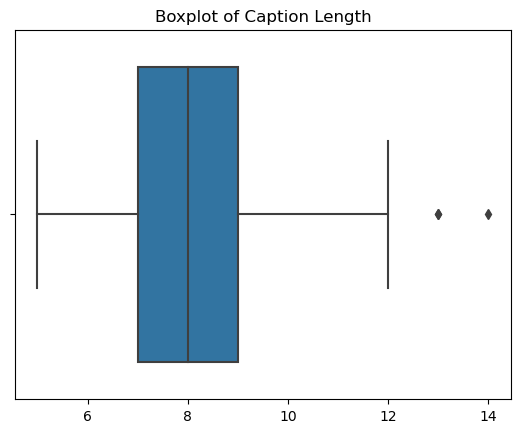

In [9]:
sns.boxplot(x=length)
plt.title("Boxplot of Caption Length")
plt.show()

In [10]:
print("Average cleaned caption length is {} words.".format(round(np.mean(length))))

Average cleaned caption length is 8 words.


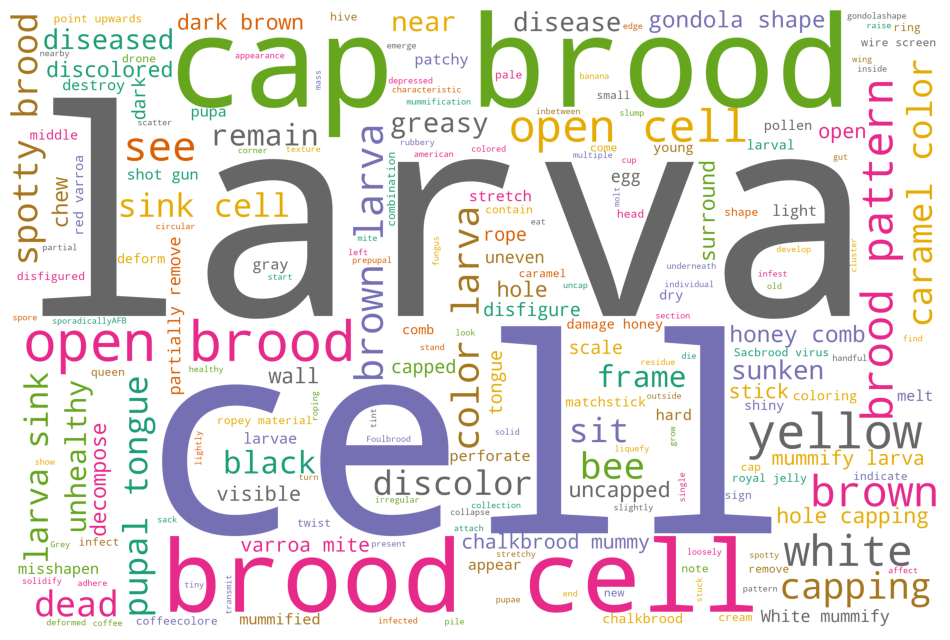

In [34]:
from wordcloud import WordCloud

# Create a long list of text for word cloud
text = " ".join(i for i in df['clean_captions'])
wordcloud = WordCloud(width = 3000, height = 2000,background_color="white", colormap='Dark2').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [59]:
# Create separate word clouds for each of the diseases

def CreateWordCloud(disease):
    text = " ".join(i for i in df[df['note']==disease]['clean_captions'])
    wordcloud = WordCloud(width = 3000, height = 2000,background_color="white", colormap='Dark2').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

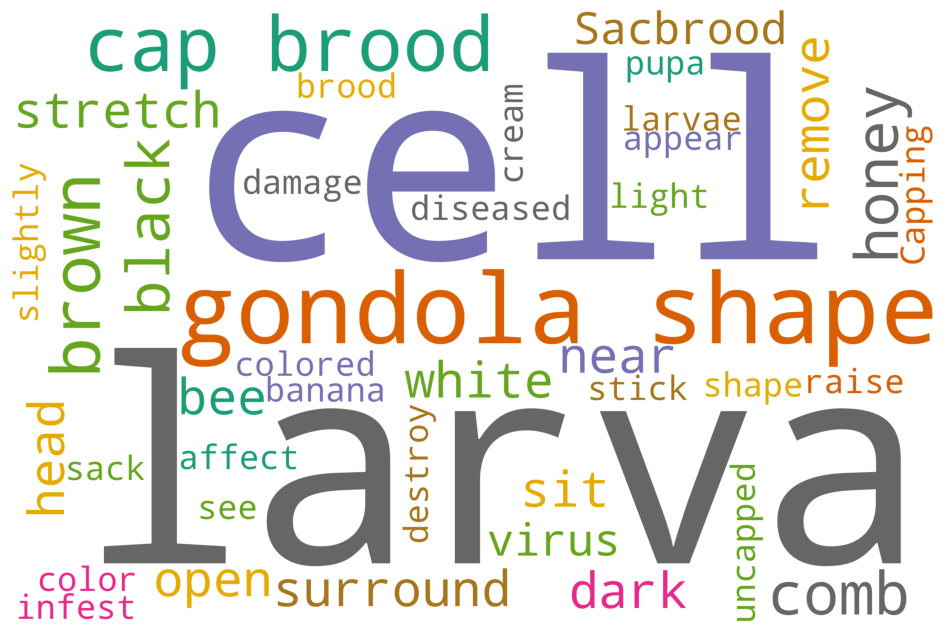

In [60]:
CreateWordCloud('sacbrood')

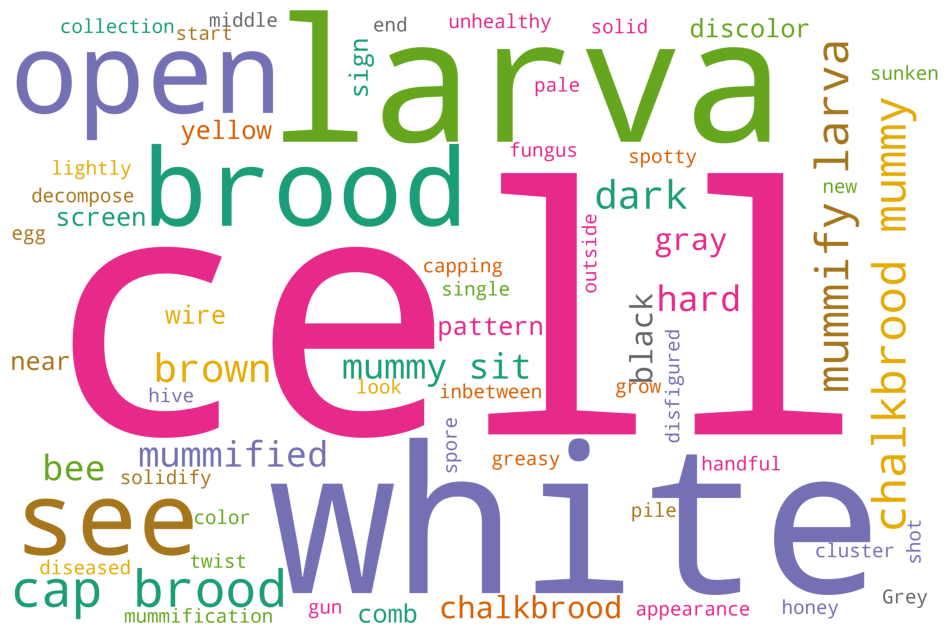

In [61]:
CreateWordCloud('chalkbrood')

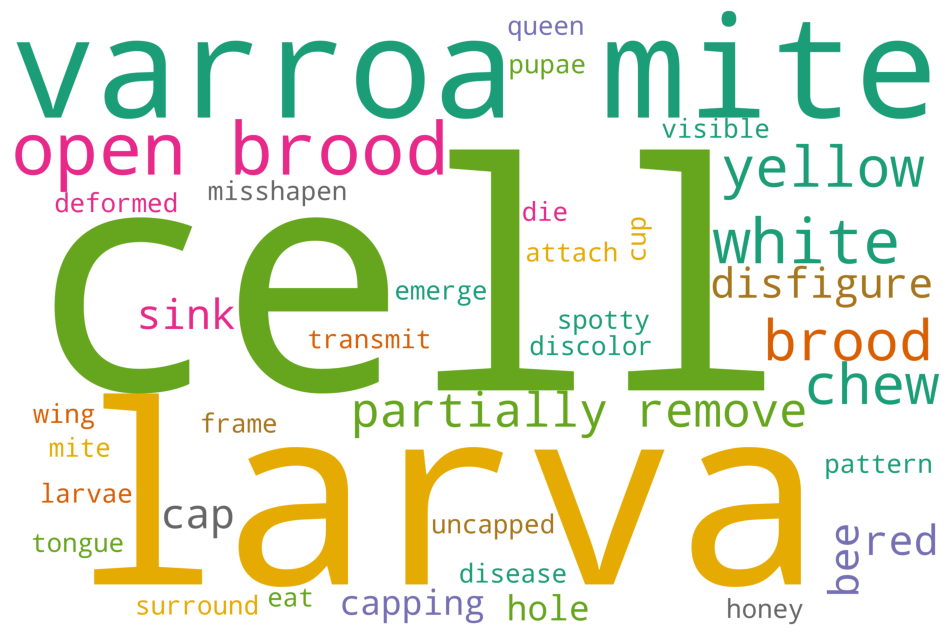

In [62]:
CreateWordCloud('pms')

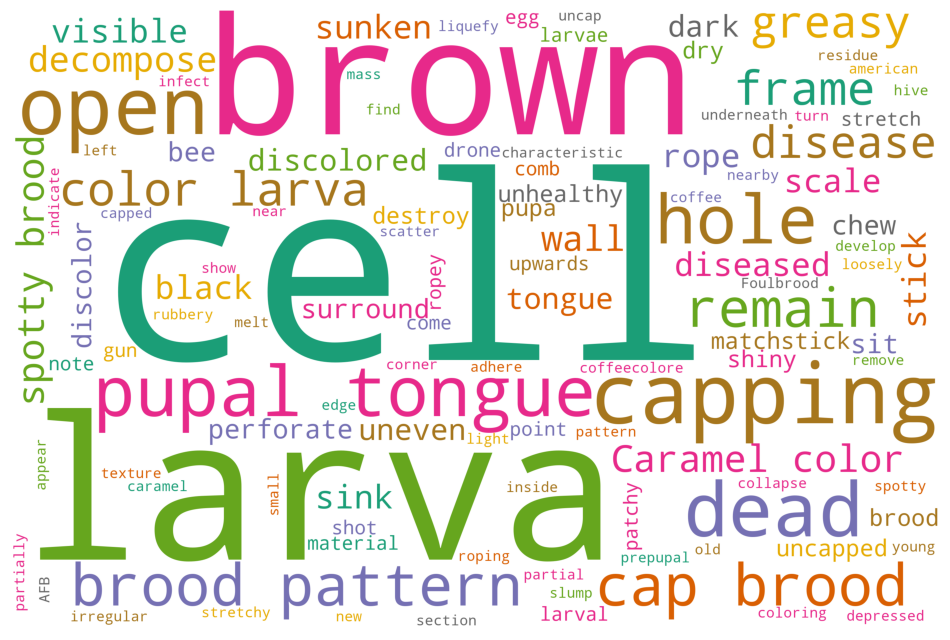

In [63]:
CreateWordCloud('afb')

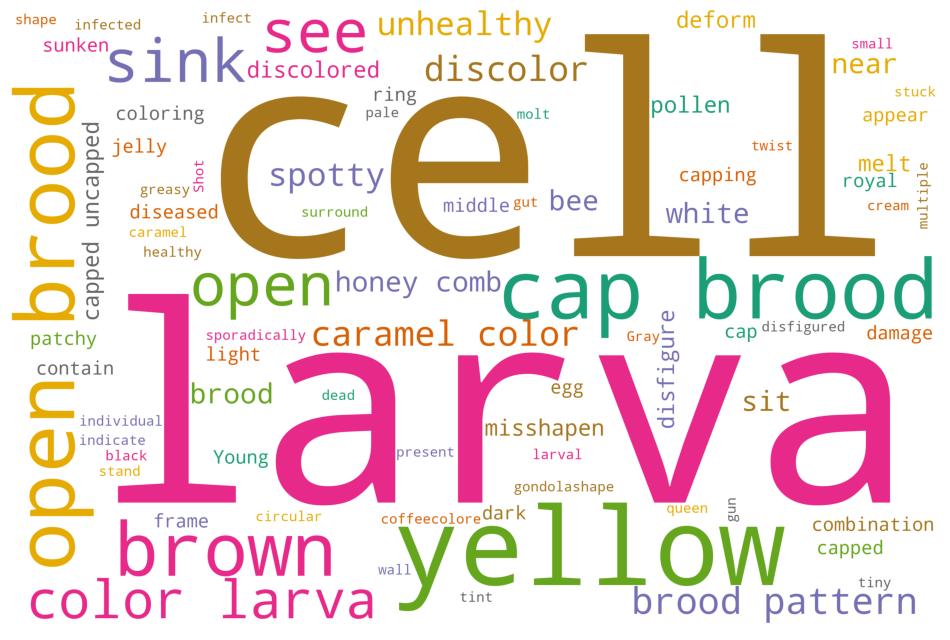

In [64]:
CreateWordCloud('efb')

### Fine-Tuned Different Models with Masked Language Modeling

The purpose of fine-tuning our masked language models is to try to improve the performance of the upcoming image classification task. We want our models to understand the words specific to our text corpus. I learned how to do this by reading [this](https://huggingface.co/course/chapter7/3?fw=tf) documentation from Hugging Face and [this](https://towardsdatascience.com/fine-tuning-for-domain-adaptation-in-nlp-c47def356fd6) documentation from Towards Data Science.

Let's create a function that allows us to easily fine-tune 3 different models (BERT, SciBERT, and Albert).

In [11]:
sequence_length = 64

def FineTuneMLM(samples, model, output_dir):
    if model == "Albert":
        checkpoint = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(checkpoint,
                                      max_length = sequence_length,
                                      truncation=True,
                                      padding="max_length",
                                      add_special_tokens=True,
                                      return_special_tokens_mask=True,
                                      return_tensors="np")
        
        # Masked language model to be tuned
        Model = AutoModelForMaskedLM 
        
    elif model == "scibert":
        checkpoint= 'allenai/scibert_scivocab_uncased'
        tokenizer = AutoTokenizer.from_pretrained(checkpoint,
                                      max_length = sequence_length,
                                      truncation=True,
                                      padding="max_length",
                                      add_special_tokens=True,
                                      return_special_tokens_mask=True,
                                      return_tensors="np")
        
        # Masked language model to be tuned
        Model = AutoModelForMaskedLM
    
    else:
        checkpoint = "bert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(checkpoint,
                                      max_length = sequence_length,
                                      truncation=True,
                                      padding="max_length",
                                      add_special_tokens=True,
                                      return_special_tokens_mask=True,
                                      return_tensors="np")
        
        # Masked language model to be tuned
        Model = BertForMaskedLM
    
    model = Model.from_pretrained(checkpoint)
    
    # Tokenized clean text and create dataframe
    tokens = tokenizer(samples.tolist())
    X_tokenized = pd.DataFrame({"input_ids": tokens["input_ids"]})
    
    # Train/test split
    X_train, X_test = train_test_split(X_tokenized, test_size=0.15, random_state=42)

    # Data collator to mask words
    data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True) # randomly mask works for training
    # mlm means masked language modeling
    
    # Create a Hugging Face dataset object
    X_train = Dataset.from_pandas(X_train)
    X_test = Dataset.from_pandas(X_test)
    
    # Create trainer the fine tunes model
    training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=4,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='loss', 
    greater_is_better=False,
    seed=42 # set random seed to reproduce results
    )

    # Fine tune the model
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=X_train,
        eval_dataset=X_test,
        tokenizer=tokenizer,
    )

    return(trainer, X_test)

#### Fine-Tune BERT

In [12]:
trainer, X_test = FineTuneMLM(df['clean_captions'], "bert", "bert-bees_final")
trainer.train()
trainer.save_model("bert-bees_final")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/opt/miniconda3/envs/pt_tf/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This impl

Epoch,Training Loss,Validation Loss
1,No log,3.564926
2,No log,3.313477
3,No log,2.879947
4,No log,2.902577


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8
Saving model checkpoint to bert-bees_final/checkpoint-21
Configuration saved in bert-bees_final/checkpoint-21/config.json
Model weights saved in bert-bees_final/checkpoint-21/pytorch_model.bin
tokenizer config file saved in bert-bees_final/checkpoint-21/tokenizer_config.json
Special tokens file saved in bert-bees_final/checkpoint-21/special_tokens_map.json
Deleting older checkpoint [bert-bees_final/checkpoint-63] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can sa

Perplexity is a metric to evaluate language models. Lower perplexity is better for language models, since perplexity is the exponential value of the loss. We will compare the perplexity of the fine-tuned models with the original (i.e. not fine-tuned) versions of the language model.

In [13]:
import math
eval_results_bert = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_bert['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8


Perplexity: 23.03


In [14]:
eval_results_bert

{'eval_loss': 3.1368279457092285,
 'eval_runtime': 0.3384,
 'eval_samples_per_second': 88.659,
 'eval_steps_per_second': 11.821,
 'epoch': 4.0}

In [15]:
# Compare fine-tuned results with original model

def CompareWithOriginal(model_checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

    data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True)
    
    trainer = Trainer(
      model=model,
      data_collator=data_collator,
      # only include the test set so we can eval on that
      eval_dataset=X_test,
      tokenizer=tokenizer,
      )
    
    return(trainer)

In [16]:
# Compare fine-tuned results with original model

trainer = CompareWithOriginal('bert-base-uncased')
eval_results_bert_ORIG = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_bert_ORIG['eval_loss']):.2f}")

loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b

Perplexity: 883.22


Now that we have done BERT, let's repeat the same for Albert and SciBert. We can create a function that does this easily for us.

#### Fine-Tune Albert

In [17]:
trainer, X_test = FineTuneMLM(df['clean_captions'], "Albert", "albert-bees-final")
trainer.train()
trainer.save_model("albert-bees-final")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--albert-base-v2/snapshots/51dbd9db43a0c6eba97f74b91ce26fface509e0b/config.json
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 64,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,


Epoch,Training Loss,Validation Loss
1,No log,5.468854
2,No log,5.323953
3,No log,4.268322
4,No log,3.742272


The following columns in the evaluation set don't have a corresponding argument in `AlbertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `AlbertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8
Saving model checkpoint to albert-bees-final/checkpoint-21
Configuration saved in albert-bees-final/checkpoint-21/config.json
Model weights saved in albert-bees-final/checkpoint-21/pytorch_model.bin
tokenizer config file saved in albert-bees-final/checkpoint-21/tokenizer_config.json
Special tokens file saved in albert-bees-final/checkpoint-21/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `AlbertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `AlbertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num exampl

In [18]:
eval_results_albert = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_albert['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `AlbertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `AlbertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8


Perplexity: 64.40


In [19]:
eval_results_albert

{'eval_loss': 4.165126323699951,
 'eval_runtime': 0.3864,
 'eval_samples_per_second': 77.639,
 'eval_steps_per_second': 10.352,
 'epoch': 4.0}

In [20]:
# Compare fine-tuned results with original model
trainer = CompareWithOriginal("albert-base-v2")
eval_results_albert_ORIG = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_albert_ORIG['eval_loss']):.2f}")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--albert-base-v2/snapshots/51dbd9db43a0c6eba97f74b91ce26fface509e0b/config.json
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embeddin

Perplexity: 13204.96


#### Fine-Tune SciBERT

In [21]:
trainer, X_test = FineTuneMLM(df['clean_captions'], "scibert", "scibert-bees-final")
trainer.train()
trainer.save_model("scibert-bees-final")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 64,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading file vocab.txt from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/m

Epoch,Training Loss,Validation Loss
1,No log,2.685965
2,No log,2.825938
3,No log,1.729510
4,No log,1.850210


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8
Saving model checkpoint to scibert-bees-final/checkpoint-21
Configuration saved in scibert-bees-final/checkpoint-21/config.json
Model weights saved in scibert-bees-final/checkpoint-21/pytorch_model.bin
tokenizer config file saved in scibert-bees-final/checkpoint-21/tokenizer_config.json
Special tokens file saved in scibert-bees-final/checkpoint-21/special_tokens_map.json
Deleting older checkpoint [scibert-bees-final/checkpoint-42] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.for

In [22]:
eval_results_scibert = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_scibert['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8


Perplexity: 18.44


In [23]:
eval_results_scibert

{'eval_loss': 2.9146811962127686,
 'eval_runtime': 0.3587,
 'eval_samples_per_second': 83.64,
 'eval_steps_per_second': 11.152,
 'epoch': 4.0}

In [24]:
# Compare fine-tuned results with original model

trainer = CompareWithOriginal('allenai/scibert_scivocab_uncased')
eval_results_scibert_ORIG = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results_scibert_ORIG['eval_loss']):.2f}")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading file vocab.txt from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--allenai--scib

Perplexity: 256.31


### Compare Results

In [38]:
compare_results = pd.DataFrame({"Fine-Tuned BERT":eval_results_bert, 
                                "BERT":eval_results_bert_ORIG, 
                                "Fine-Tuned Albert": eval_results_albert,
                                "Albert": eval_results_albert_ORIG,
                                "Fine-Tuned SciBERT":eval_results_scibert,
                                "SciBERT":eval_results_scibert_ORIG
                               })
compare_results.drop(["eval_runtime", "eval_samples_per_second",
                      "eval_steps_per_second", "epoch"], axis=0, inplace = True)
compare_results = compare_results.T
compare_results

,eval_loss
Fine-Tuned BERT,3.136828
BERT,6.783573
Fine-Tuned Albert,4.165126
Albert,9.488348
Fine-Tuned SciBERT,2.914681
SciBERT,5.546381


In [43]:
compare_results['perplexity'] = np.exp(compare_results['eval_loss'])
compare_results

,eval_loss,perplexity
Fine-Tuned BERT,3.136828,23.030696
BERT,6.783573,883.218546
Fine-Tuned Albert,4.165126,64.400817
Albert,9.488348,13204.962795
Fine-Tuned SciBERT,2.914681,18.442932
SciBERT,5.546381,256.308173


We can see that SciBERT has the lowest perplexity!

In [60]:
compare_results_subset = compare_results.loc[['Fine-Tuned BERT', 'Fine-Tuned Albert',
                                                'Fine-Tuned SciBERT']]
compare_results_subset.sort_values('perplexity', inplace=True)

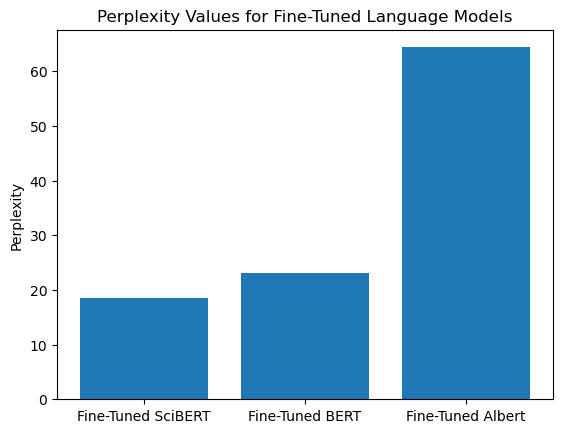

In [62]:
plt.title("Perplexity Values for Fine-Tuned Language Models")
plt.bar(x=compare_results_subset.index, height=compare_results_subset['perplexity'])
plt.ylabel("Perplexity")
plt.show()